In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, f_classif

In [227]:
df = pd.read_csv('Customer-Churn-Records.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### The goal is to predict whether a customer leaves a bank or not. Customer acquisition cost is high, so it is of interest to a bank to be able to predict whether a customer is likely to leave, or not.
### Let's start commenting on the different features at play, and then create a new df that omits the irrelevant features
- RowNumber: does not affect customer's decision to exit
- CustomerId: same, does not affect decision to exit
- Surname: Again, nothing
- CreditScore: Might not affect, since having a high credit score leaves you satisfied. Having a low one makes you wary to switch banks and incur temporary drop in credit score (assuming credit is linked to bank account). At the same time high credit score might be correlated positively with age, and older people are less likely to exit? 
- Geography: Interesting to see how customers in Europe/NA compare to those in Eastern Hemisphere. I suspect those in Eastern Hemisphere are more risk-averse
- Gender: Truly no idea, but I suspect there might be a bias. Will need a lot of data to get a signal that may be weak here!
- Age: I think this will be a strong predictor
- Tenure: The longer you've been with the bank, the more satisfied you are. Should correlate negatively with probability of exit
- Balance: Might be similar to credit score, but I will it will be a stronger predictor. Those with higher balances are more stable, and less likely to leave
- NumOfProducts: The more products, the more bound you are to the bank, no?
- HasCrCard: This will be interesting to look at in conjunction with credit score
- IsActiveMember: The more active you are, the more likely you are to stay. But at the same time, maybe if you are completely not active, you are also less likely to make moves? Extreme example: a dead customer does not exit.
- EstimatedSalary: Higher salaries should mean less likely to leave
- Exited: TARGET!
- Complain: The most straightforward predictor
- Satisfaction Score: Another straightforward predictor
- Card Type: Cardholders with the higher tier card types are less likely to leave
- Point Earned: High points should also mean less likely to leave

### Other questions that dataset does not answer. What about closed accounts? Estimated salary is current salary? 

### So far so good. Let's get some more information about our dataset itself.

In [228]:
print(df.shape)

(10000, 18)


In [229]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


In [230]:
print("All countries:", df['Geography'].unique())
print("Card Types", df['Card Type'].unique())

All countries: ['France' 'Spain' 'Germany']
Card Types ['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']


### Okay, that's a shame because we have no data from customers not from those 3 countries. I guess it makes sense because other factors like salary, for instance, would need to be normalized for proper comparison.

### Clean dataframe:

In [231]:
df_churn = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1) #drop irrelevant labels

#map non numeric categorical data into numeric
df_churn['Geography'] = df_churn['Geography'].map({'France': 0, 'Spain': 1, 'Germany' : 2})
df_churn['Card Type'] = df_churn['Card Type'].map({'SILVER': 0, 'GOLD': 1, 'PLATINUM' : 2, 'DIAMOND': 3}) #Diamond > Platinum > Gold > Silver
df_churn['Gender'] = df_churn['Gender'].map({'Male': 0, 'Female': 1}) #Diamond > Platinum > Gold > Silver

#rename annoying column names
df_churn = df_churn.rename(columns = {'Point Earned': 'PointsEarned', 'Satisfaction Score': 'SatScore', 'IsActiveMember': 'Active',\
                                     'Card Type': 'CardType'})

df_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,Active,EstimatedSalary,Exited,Complain,SatScore,CardType,PointsEarned
0,619,0,1,42,2,0.00,1,1,1,101348.88,1,1,2,3,464
1,608,1,1,41,1,83807.86,1,0,1,112542.58,0,1,3,3,456
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1,1,3,3,377
3,699,0,1,39,1,0.00,2,0,0,93826.63,0,0,5,1,350
4,850,1,1,43,2,125510.82,1,1,1,79084.10,0,0,5,1,425


## Correlations

#### Here's a problem. Some of our features are discrete (e.g. Number of products). Others, like Estimated Salary are continuous. So we can't just use the Pearson correlation. Pearson assumes the data follow normal distributions (roughly), no outliers are present, and that they are related linearly. We violate normality with discrete variables, so let's turn to Spearman correlation, instead

#### Another option is the Spearman correlation, which is less sensitive to outliers. The way to compute it between two variables $X$ and $Y$ is to rank $X$ in (ascending) order. Same for $Y$. Call the ranks $R_x$ and $R_y$. Compute the difference between the two: $d$. 
#### $\rho = 1-\frac{\Sigma_i 6d_i^2}{n(n^2-1)}$
#### Here's the issue: Spearman handles ties poorly!

#### We need a different correlation metric. Enter Kendall-Tau metric which handles ties $\tau = (P-Q) /\sqrt{(P+Q+T)(P+Q+U)}$, where $P$ is number of concordant pairs, $Q$ is number of discordant pairs, $T$ and $U$ are number of ties appearing only in $x_1$ and $x_2$ respectively

#### For now, we will refrain from computing correlations, which is a weird concept in the context of categorical data, anyway. 

## Visualization

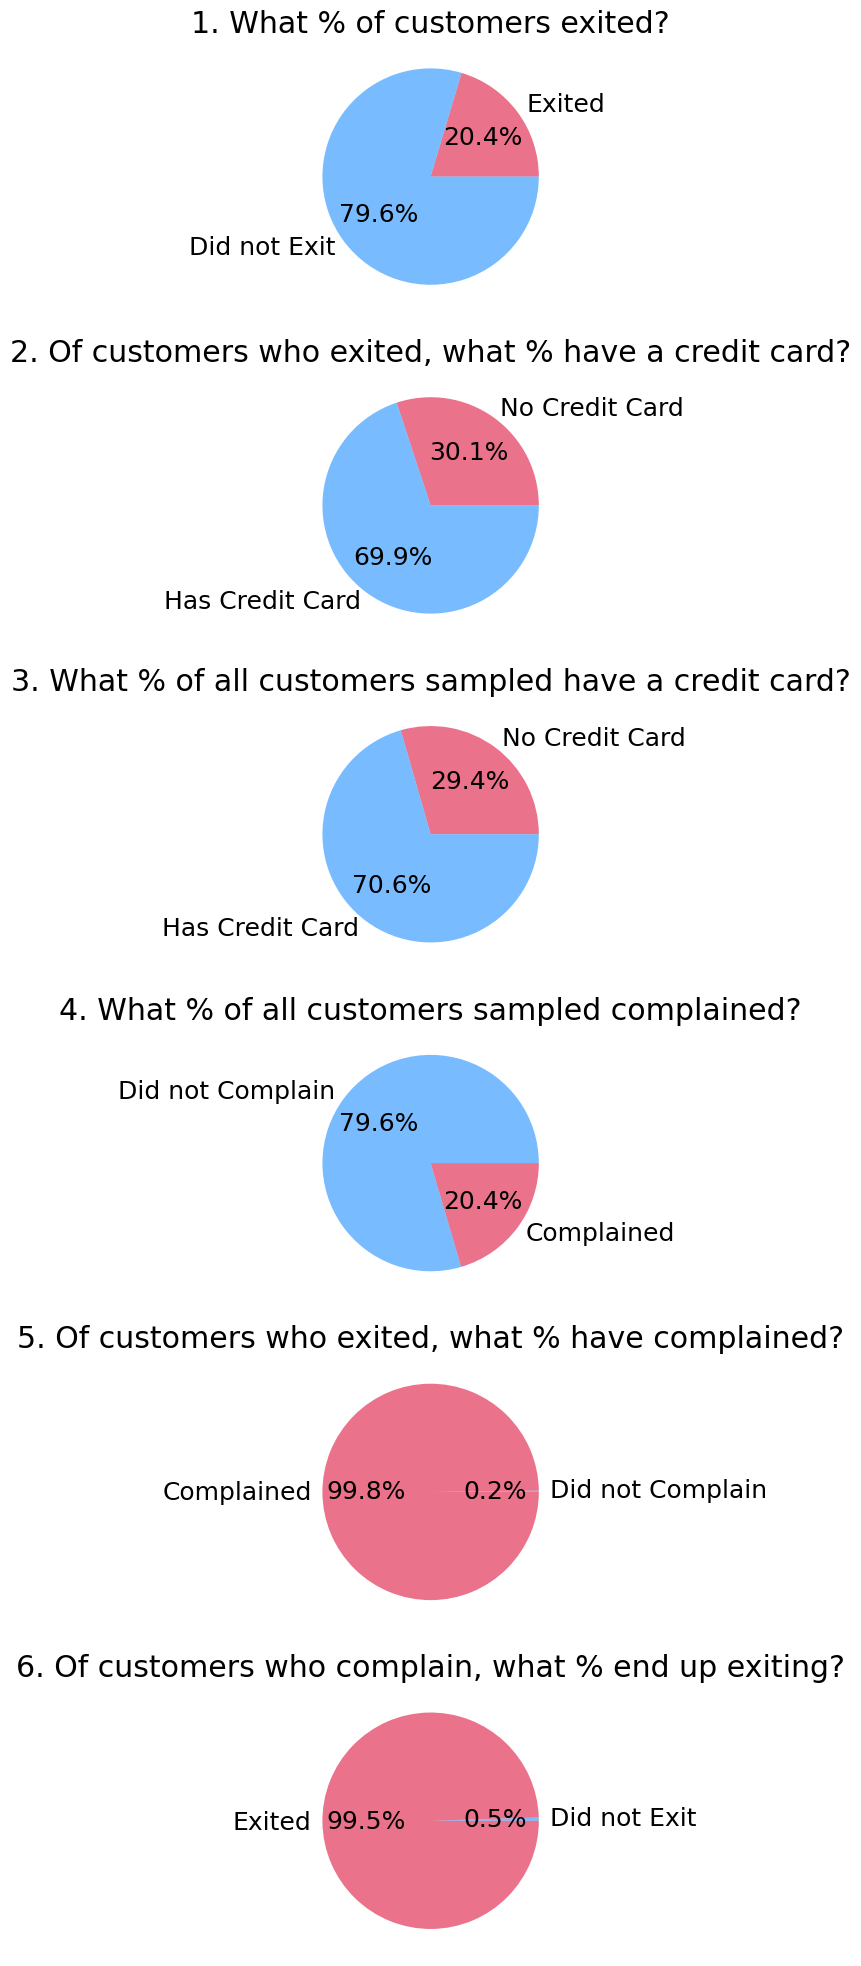

In [232]:
font = {'family': 'sans-serif', 'size': 18}
plt.rc('font', **font)
lw = 2. #linewidth for all plots

fig, axs = plt.subplots(6, figsize = (8,20))

labels = 'Exited', 'Did not Exit'
l_ex = len(df_churn[df_churn['Exited'] == 1])/len(df_churn) * 100.
l_nex = 100. - l_ex
sizes = [l_ex, l_nex]
ax = axs[0]
ax.set_title('1. What % of customers exited?')
p = ax.pie(sizes, labels=labels, colors = ['crimson', 'dodgerblue'], autopct='%1.1f%%', wedgeprops={"alpha": 0.6})

labels = 'No Credit Card', 'Has Credit Card'
ax = axs[1]
ax.set_title('2. Of customers who exited, what % have a credit card?')
df_exit = df_churn[df_churn['Exited'] == 1]
sizes = []
for i in [0, 1]:
    sizes.append(len(df_exit[df_exit.HasCrCard == i]))
p = ax.pie(sizes, labels=labels, colors = ['crimson', 'dodgerblue'], autopct='%1.1f%%', wedgeprops={"alpha": 0.6})
for ax in axs:
    ax.tick_params(axis="y", direction="in", length = 4)
    ax.tick_params(axis="x", direction="in", length = 4)

ax = axs[2]
ax.set_title('3. What % of all customers sampled have a credit card?')
sizes = []
for i in [0, 1]:
    sizes.append(len(df_churn[df_churn.HasCrCard == i]))
p = ax.pie(sizes, labels=labels, colors = ['crimson', 'dodgerblue'], autopct='%1.1f%%', wedgeprops={"alpha": 0.6})
for ax in axs:
    ax.tick_params(axis="y", direction="in", length = 4)
    ax.tick_params(axis="x", direction="in", length = 4)

labels = 'Did not Complain', 'Complained'
ax = axs[3]
ax.set_title('4. What % of all customers sampled complained?')
sizes = []
for i in [0, 1]:
    sizes.append(len(df_churn[df_churn.Complain == i]))
p = ax.pie(sizes, labels=labels, colors = ['dodgerblue', 'crimson'], autopct='%1.1f%%', wedgeprops={"alpha": 0.6})
for ax in axs:
    ax.tick_params(axis="y", direction="in", length = 4)
    ax.tick_params(axis="x", direction="in", length = 4)

ax = axs[4]
ax.set_title('5. Of customers who exited, what % have complained?')
df_exit = df_churn[df_churn['Exited'] == 1]
sizes = []
for i in [0, 1]:
    sizes.append(len(df_exit[df_exit.Complain == i]))
p = ax.pie(sizes, labels=labels, colors = ['dodgerblue', 'crimson'], autopct='%1.1f%%', wedgeprops={"alpha": 0.6})
for ax in axs:
    ax.tick_params(axis="y", direction="in", length = 4)
    ax.tick_params(axis="x", direction="in", length = 4)

labels = 'Did not Exit', 'Exited'
ax = axs[5]
ax.set_title('6. Of customers who complain, what % end up exiting?')
df_comp = df_churn[df_churn['Complain'] == 1]
sizes = []
for i in [0, 1]:
    sizes.append(len(df_comp[df_comp.Exited == i]))
p = ax.pie(sizes, labels=labels, colors = ['dodgerblue', 'crimson'], autopct='%1.1f%%', wedgeprops={"alpha": 0.6})
for ax in axs:
    ax.tick_params(axis="y", direction="in", length = 4)
    ax.tick_params(axis="x", direction="in", length = 4)

plt.tight_layout()

### From the second pie chart, one might hypothesize that having a credit disproportionately means that you will exit. But the third pie chart suggests that it is not true.
### In contrast, look at that last pie chart! Hardly any customer exited without complaining. Now that's a strong signal. How about this -- only 5 in a 1000 customers who complained remained. That is a terrible retention rate of customers who expressed dissatisfaction.

### Enough of pie charts! I'm no longer hungry, let's move to other visualizations

C:\Users\ajati\AppData\Local\Temp\ipykernel_21708\1424348713.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c1_counts = c1.groupby(bins)['Age'].count()
C:\Users\ajati\AppData\Local\Temp\ipykernel_21708\1424348713.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c0_counts = c0.groupby(bins)['Age'].count()


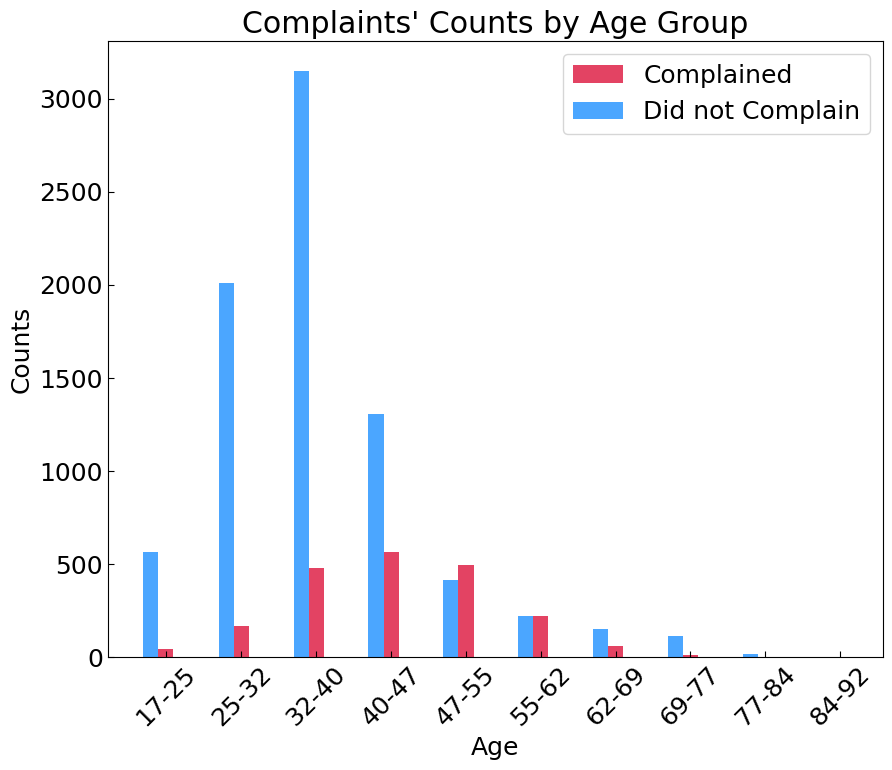

In [233]:
bins = pd.cut(df_churn['Age'], bins=10)
c1 = df_churn[df_churn['Complain'] == 1]
c0 = df_churn[df_churn['Complain'] == 0]
c1_counts = c1.groupby(bins)['Age'].count()
c0_counts = c0.groupby(bins)['Age'].count()

fig, ax = plt.subplots(figsize = (10, 8))
bw = 1.5
ax.bar(c1_counts.index.categories.left + bw/2, c1_counts, width=bw, color='crimson', label='Complained', alpha = .8)
ax.bar(c0_counts.index.categories.left - bw/2, c0_counts, width=bw, color='dodgerblue', label='Did not Complain', alpha = .8)
ax.set_xlabel('Age')
ax.set_ylabel('Counts')
ax.set_title("Complaints' Counts by Age Group")
ax.legend()
ax.tick_params(axis="y", direction="in", length = 4)
ax.tick_params(axis="x", direction="in", length = 4)

ax.set_xticks(ticks=c0_counts.index.categories.left + bw/2, labels=[f'{int(left)}-{int(right)}'\
                                                                            for left, right in zip(c0_counts.index.categories.left, c0_counts.index.categories.right)],\
             rotation = 45);

### Just fascinating how younger folks hate to complain, and while there isn't much data for much older folks, that appears to be somewhat true too. For people in the 40-60 age group, the matter is entirely different!

C:\Users\ajati\AppData\Local\Temp\ipykernel_21708\2335753309.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  E1_counts = E1.groupby(bins)['Age'].count()
C:\Users\ajati\AppData\Local\Temp\ipykernel_21708\2335753309.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  E0_counts = E0.groupby(bins)['Age'].count()


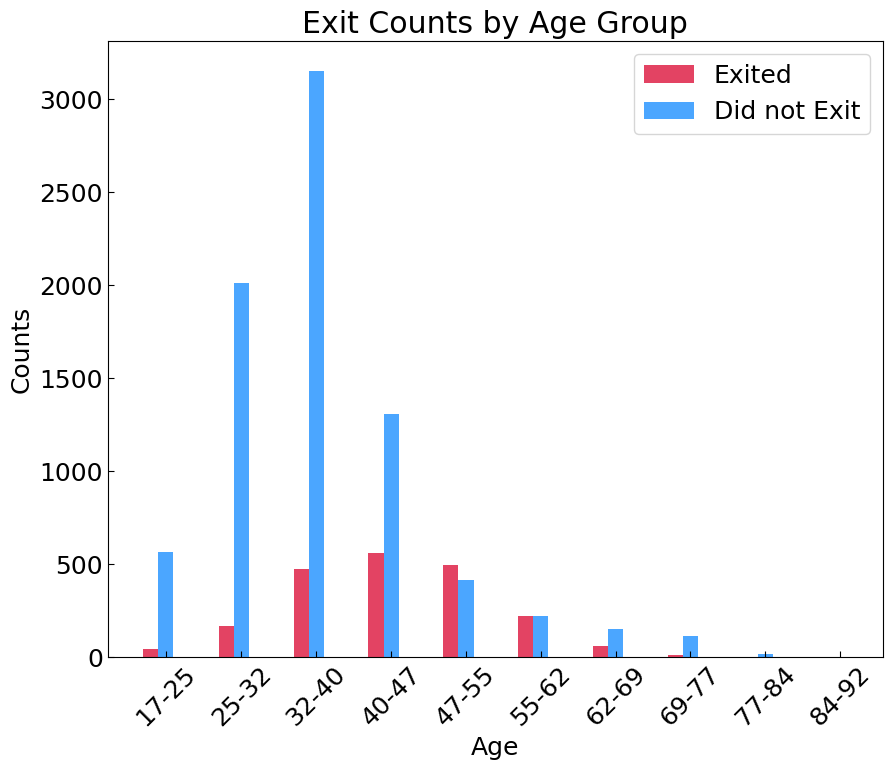

In [234]:
E1 = df_churn[df_churn['Exited'] == 1]
E0 = df_churn[df_churn['Exited'] == 0]
E1_counts = E1.groupby(bins)['Age'].count()
E0_counts = E0.groupby(bins)['Age'].count()

fig, ax = plt.subplots(figsize = (10, 8))
bw = 1.5
ax.bar(E1_counts.index.categories.left - bw/2, E1_counts, width=bw, color='crimson', label='Exited', alpha = .8)
ax.bar(E0_counts.index.categories.left + bw/2, E0_counts, width=bw, color='dodgerblue', label='Did not Exit', alpha = .8)
ax.set_xlabel('Age')
ax.set_ylabel('Counts')
ax.set_title("Exit Counts by Age Group")
ax.legend()
ax.tick_params(axis="y", direction="in", length = 4)
ax.tick_params(axis="x", direction="in", length = 4)

ax.set_xticks(ticks=E0_counts.index.categories.left + bw/2, labels=[f'{int(left)}-{int(right)}'\
                                                                            for left, right in zip(E0_counts.index.categories.left, E0_counts.index.categories.right)],\
             rotation = 45);

### As earlier, strong strong correlation between complaining and exiting.

## Feature selection with Mutual Information Score

C:\Users\ajati\AppData\Local\Temp\ipykernel_21708\3113872363.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI', y='X', data=mi_df, palette='coolwarm')


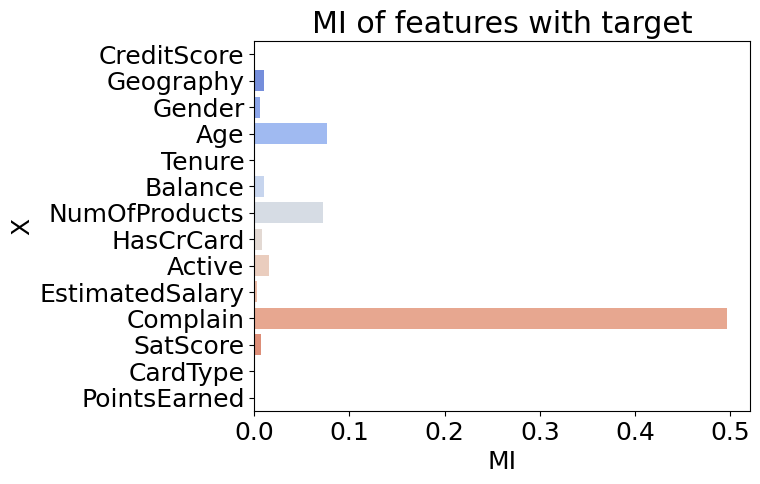

C:\Users\ajati\AppData\Local\Temp\ipykernel_21708\3113872363.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='f-score', y='X', data=ANOVA_df, palette='coolwarm')


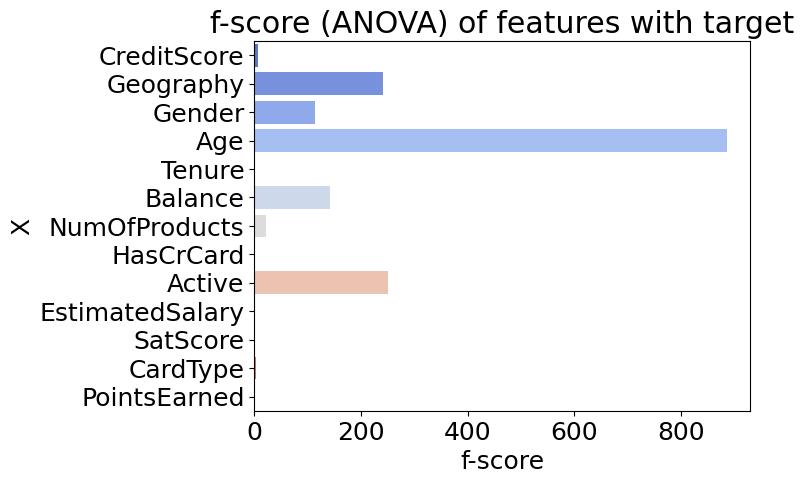

In [235]:
X = df_churn[[col for col in df_churn.columns if col != 'Exited']]
mi = mutual_info_classif(X, df_churn.Exited)
mi_df = pd.DataFrame({'X': X.columns, 'MI': mi})

fig, ax = plt.subplots()
sns.barplot(x='MI', y='X', data=mi_df, palette='coolwarm')
p = ax.set_title('MI of features with target')
plt.show()

X = df_churn.drop(columns = {'Exited', 'Complain'}, axis=1) #actually, that's an easier way to select the features. We will drop complain column
    #as well, because it is way too strong of a predictor and the scale will be completely off for f-scores of other predictors, if we include it
Y = df_churn['Exited']
ANOVA = f_classif(X, Y)
ANOVA_df = pd.DataFrame({'X': X.columns, 'f-score': ANOVA[0]})

fig, ax = plt.subplots()
sns.barplot(x='f-score', y='X', data=ANOVA_df, palette='coolwarm')
p = ax.set_title('f-score (ANOVA) of features with target')
plt.show()

#### Based on the mutual information score (scaled) and the f-score from ANOVA (unscaled), after complain, age, geography, gender might be the most useful predictors

In [236]:
df_churn.to_csv('df_churn.csv', index=False)